In [1]:
library(modelr)
library(tidyverse)
library(lubridate)
theme_set(theme_minimal())
options(repr.plot.width=6, repr.plot.height=4)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.2.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



### Review problem
Use logistic regression to model the probability that a flight's departure delayed by more than one hour given the amount of precipitation that occurred that day.

- What is the predicted probability of delay if it doesn't rain at all?
- What is the predicted probability of delay if it rains an inch?

(Assume rain == precipitation)

In [17]:
library(nycflights13)
df <- flights %>% mutate(long_delay = dep_delay > 60) %>% left_join(weather)
mdl <- glm(long_delay ~ precip, data = df, family = "binomial")
tibble(precip=c(0, 1)) %>% add_predictions(mdl) %>% mutate(p = plogis(pred))

Joining, by = c("year", "month", "day", "origin", "hour", "time_hour")


precip,pred,p
0,-2.461279,0.07861763
1,2.480978,0.92279748


# Lecture 21: Models for binary outcomes (logistic regression)

We pick up where we left off at the end of last week with studying logistic regression:

### Example: Image classification
We will use logistic regression to build an image classifier. We will train a model that recognizes the number 5.

In [18]:
load("../lecture20/mnist.RData")

The `mnist` table is a data frame with 60000 observations and 785 columns. Each row corresponds to a handwritten digit. The first column is the label of that image, and the next $784=28^2$ columns are pixel data for each image. 

In [74]:
mnist %>% slice(1) %>% print
plot_images <- function(df) {
    df %>% mutate(i=row_number()) %>% 
    gather("k", "v", X2:X785) %>% mutate(px = as.numeric(str_sub(k, 2)) - 2,
                                         x = px %% 28,
                                         y = 28 - (px %/% 28)) %>% 
    ggplot() + geom_tile(aes(x=x, y=y, fill=v)) + facet_wrap(~ i) + 
    scale_fill_gradient(low="white", high="black")
}

# A tibble: 1 x 785
     X1    X2    X3    X4    X5    X6    X7    X8    X9   X10   X11   X12   X13
  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1     5     0     0     0     0     0     0     0     0     0     0     0     0
# ... with 772 more variables: X14 <dbl>, X15 <dbl>, X16 <dbl>, X17 <dbl>,
#   X18 <dbl>, X19 <dbl>, X20 <dbl>, X21 <dbl>, X22 <dbl>, X23 <dbl>,
#   X24 <dbl>, X25 <dbl>, X26 <dbl>, X27 <dbl>, X28 <dbl>, X29 <dbl>,
#   X30 <dbl>, X31 <dbl>, X32 <dbl>, X33 <dbl>, X34 <dbl>, X35 <dbl>,
#   X36 <dbl>, X37 <dbl>, X38 <dbl>, X39 <dbl>, X40 <dbl>, X41 <dbl>,
#   X42 <dbl>, X43 <dbl>, X44 <dbl>, X45 <dbl>, X46 <dbl>, X47 <dbl>,
#   X48 <dbl>, X49 <dbl>, X50 <dbl>, X51 <dbl>, X52 <dbl>, X53 <dbl>,
#   X54 <dbl>, X55 <dbl>, X56 <dbl>, X57 <dbl>, X58 <dbl>, X59 <dbl>,
#   X60 <dbl>, X61 <dbl>, X62 <dbl>, X63 <dbl>, X64 <dbl>, X65 <dbl>,
#   X66 <dbl>, X67 <dbl>, X68 <dbl>, X69 <dbl>, X70 <dbl>, X71 <dbl>,
#   X72 <dbl>, X73 <dbl>, X74 <dbl>

### Challenge problem
Use logistic regression to build an image classifier that tells whether or not the image is a "5".

In [19]:
train <- slice(mnist, 1:50000)
test <- slice(mnist, -(1:50000))

<img width=100 style="float:left; margin: 0 10px 0 0; " src="https://si.wsj.net/public/resources/images/OB-SS880_scream_DV_20120426110240.jpg"/> 

## My code is too slow!

Last lecture we saw that trying to use logistic regression on this data set made things too slow.
```{r}
glm(I(X1 == 5) ~ ., data = train)  # too slow
```

If we look back at the pictures, we see that a lot of the data columns a extraneous. For example:

In [48]:
summary(select(train, X2:X10))

       X2          X3          X4          X5          X6          X7   
 Min.   :0   Min.   :0   Min.   :0   Min.   :0   Min.   :0   Min.   :0  
 1st Qu.:0   1st Qu.:0   1st Qu.:0   1st Qu.:0   1st Qu.:0   1st Qu.:0  
 Median :0   Median :0   Median :0   Median :0   Median :0   Median :0  
 Mean   :0   Mean   :0   Mean   :0   Mean   :0   Mean   :0   Mean   :0  
 3rd Qu.:0   3rd Qu.:0   3rd Qu.:0   3rd Qu.:0   3rd Qu.:0   3rd Qu.:0  
 Max.   :0   Max.   :0   Max.   :0   Max.   :0   Max.   :0   Max.   :0  
       X8          X9         X10   
 Min.   :0   Min.   :0   Min.   :0  
 1st Qu.:0   1st Qu.:0   1st Qu.:0  
 Median :0   Median :0   Median :0  
 Mean   :0   Mean   :0   Mean   :0  
 3rd Qu.:0   3rd Qu.:0   3rd Qu.:0  
 Max.   :0   Max.   :0   Max.   :0  

This is a good moment to talk about *dimensionality reduction*. Nowadays we often find ourselves in a situation where there is too much data to do analysis. It can be useful to try and reduce the size of the data. The best-known method for dimensionality reduction is called Principle Components Analysis (PCA). 

In [116]:
pca <- prcomp(train[, 2:785], center=F, scale=F)

The idea of PCA is to find a more efficient way of representing our data. In particular, PCA will find new images that can be used to efficiently represent the original images. To better understand what this means,
let's look at some of those images:

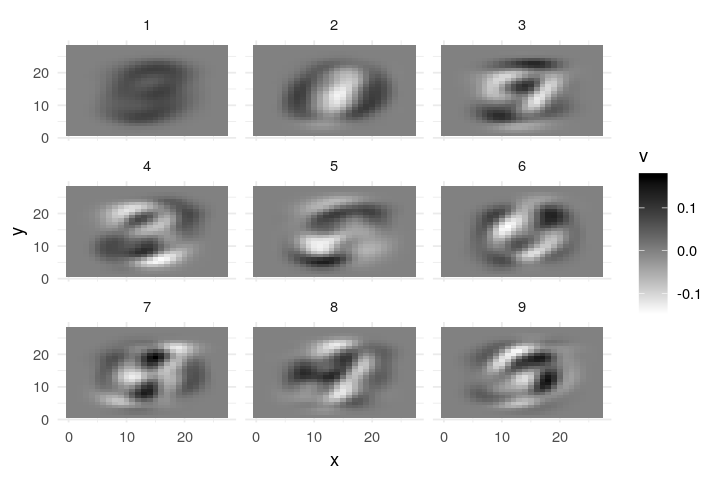

In [117]:
t(pca$rotation[,1:9]) %>% as_tibble %>% plot_images

These are the first nine principal components. We can write each of our (handwritten digits) as linear combination of these pictures -- literally adding them up.

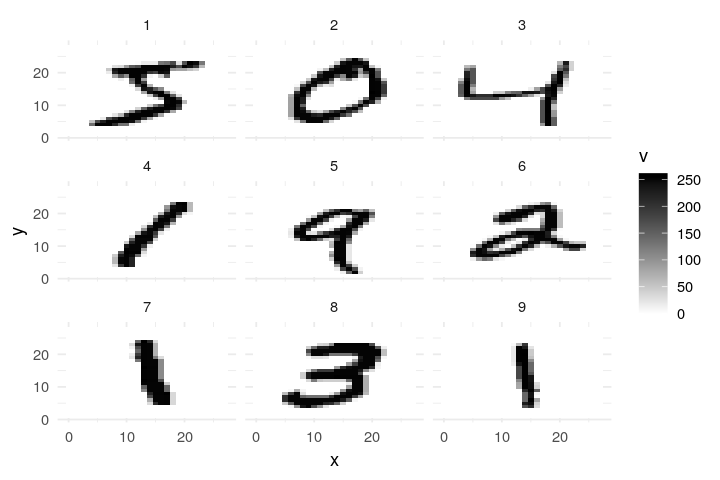

In [118]:
plot_images(train[1:9,])

By varying the number of principal components that we use to represent each image, we obtain progressively better results using less data:

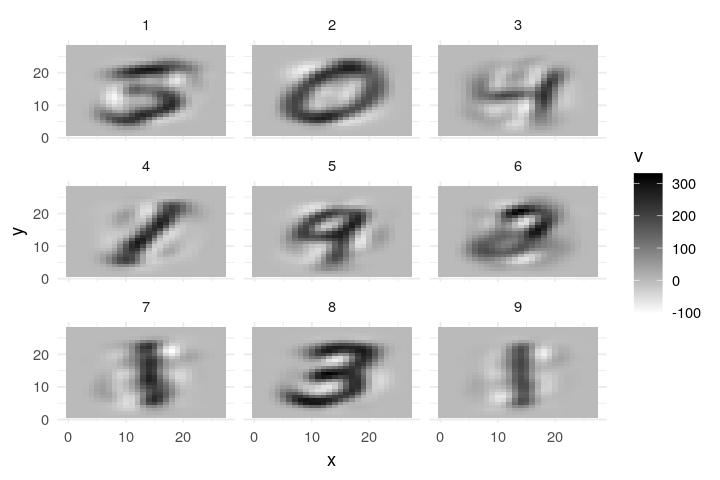

In [139]:
K <- 20  # Number of principal components
P <- pca$rotation[, 1:K]
projected = as_tibble(scale(train[, -1], pca$center, pca$scale) %*% P %*% t(P))
names(projected) <- names(train)[-1]
plot_images(projected[1:9, ])

Now let us see how dimensionality reduction has helped out when trying to fit the logistic regression. Instead of using the complete data set, we will only use the top $k$ principal components:

In [193]:
y <- train$X1 == 5
K <- 100  # Number of principal components
P <- pca$rotation[, 1:K]
X = scale(train[, -1], pca$center, pca$scale) %*% P
df <- as_tibble(X)
colnames(df) <- colnames(X)
df$y <- y
mdl <- glm(y ~ ., df, family="binomial")


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

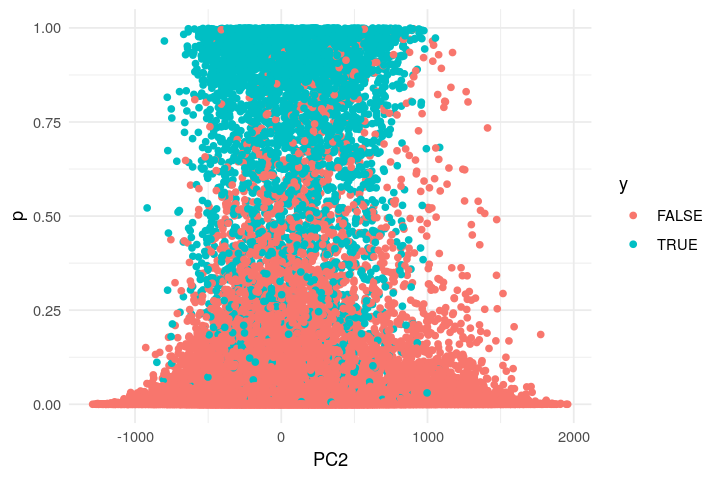

In [200]:
df %>% add_predictions(mdl) %>% mutate(p = plogis(pred)) %>%
    ggplot + geom_point(aes(x=PC2, y=p, colour=y))

## Test error
To test how well our model does, we will calculate its test error. Our measure of the error will be the (negative) log-likelihood of observing each observation under our model, defined as:

$$\text{loss} = -\sum_i y_i \log(\hat{p}_i) + (1 - y_i) \log(1-\hat{p}_i)$$

In [204]:
Xtest <- scale(test[, -1], pca$center, pca$scale) %*% P
df <- as_tibble(Xtest)
colnames(df) <- colnames(Xtest)
df$y <- test$X1 == 5
test_err <- df %>% add_predictions(mdl) %>% mutate(p = plogis(pred), 
                                                   error = -(y * log(p) + (1 - y) * log1p(-p)))
sum(test_err$error)

[1] 1055.31

### Challenge problem
Minimize the test error!

## Application: Cancer biology

The file `brca.RData` contains gene expression measurements cancer and normal patients:

In [11]:
load('brca.RData')
print(normal)

# A tibble: 17,814 x 62
   `Hybridization … `TCGA-BH-A0AY-1… `TCGA-A7-A0DB-1… `TCGA-BH-A0HK-1…
   <chr>                       <dbl>            <dbl>            <dbl>
 1 ELMO2                      0.204            0.869            0.0645
 2 CREB3L1                   -0.242            0.878            0.274 
 3 RPS11                      0.592           -0.0246           0.478 
 4 PNMA1                      0.538            0.820            0.290 
 5 MMP2                       0.708            1.93             0.99  
 6 C10orf90                   0.276           -0.418           -0.109 
 7 ZHX3                      -0.117            0.571            0.204 
 8 ERCC5                      0.518            0.501            0.035 
 9 GPR98                     -0.0184          -2.13            -0.525 
10 RXFP3                     -0.059            0.595            0.011 
# ... with 17,804 more rows, and 58 more variables:
#   `TCGA-BH-A0BM-11A-12R-A089-07` <dbl>, `TCGA-BH-A0B3-11B-21R-A089-07`

In [12]:
print(cancer)

# A tibble: 17,814 x 62
   `Hybridization … `TCGA-BH-A0AY-1… `TCGA-A7-A0DB-1… `TCGA-BH-A0HK-1…
   <chr>                       <dbl>            <dbl>            <dbl>
 1 ELMO2                      0.204            0.869            0.0645
 2 CREB3L1                   -0.242            0.878            0.274 
 3 RPS11                      0.592           -0.0246           0.478 
 4 PNMA1                      0.538            0.820            0.290 
 5 MMP2                       0.708            1.93             0.99  
 6 C10orf90                   0.276           -0.418           -0.109 
 7 ZHX3                      -0.117            0.571            0.204 
 8 ERCC5                      0.518            0.501            0.035 
 9 GPR98                     -0.0184          -2.13            -0.525 
10 RXFP3                     -0.059            0.595            0.011 
# ... with 17,804 more rows, and 58 more variables:
#   `TCGA-BH-A0BM-11A-12R-A089-07` <dbl>, `TCGA-BH-A0B3-11B-21R-A089-07`

Each row represents a gene, and each column a patient. The data are measurements of how expressed each gene was in that patient. Certain cancers are known to activate certain genes, resulting in elevated expression levels. These expression levels can be used to determine what (sub-)type of cancer you have.

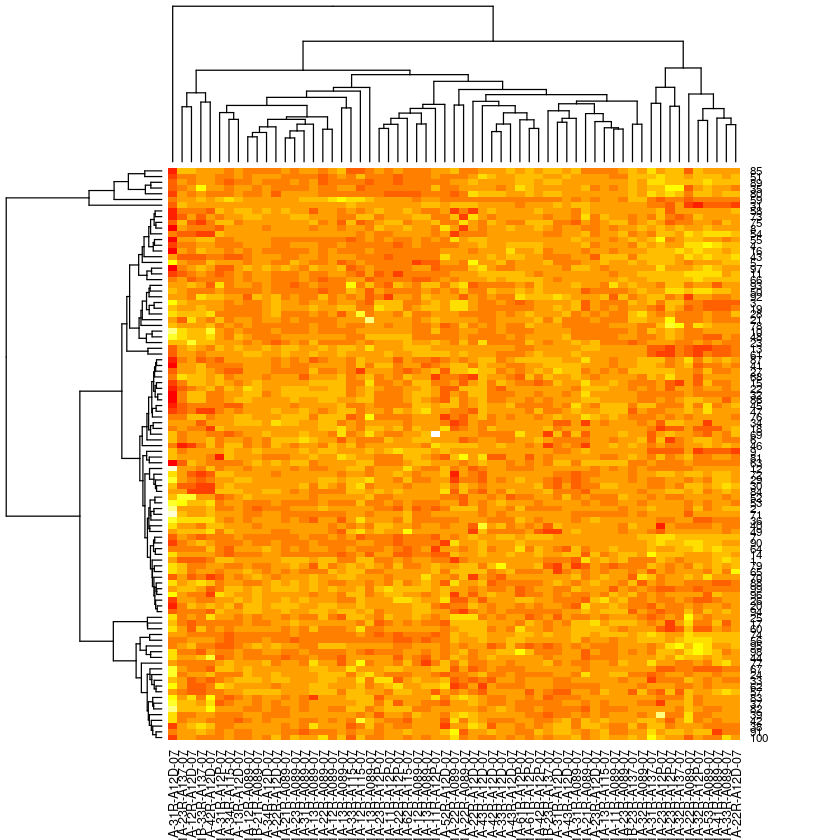

In [19]:
heatmap(as.matrix(normal[1:100,-1]))

## Challenge Problem
Develop something that classifies cancer vs. normal patients on the basis of gene expression data.